In [353]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import missingno as msno

players = pd.read_csv('./Dataset/players.csv')
teams = pd.read_csv('./Dataset/teams.csv')
players_teams = pd.read_csv('./Dataset/players_teams.csv')
awards_players = pd.read_csv('./Dataset/awards_players.csv')
coaches = pd.read_csv('./Dataset/coaches.csv')
series_post = pd.read_csv('./Dataset/series_post.csv')
teams_post = pd.read_csv('./Dataset/teams_post.csv')

hugo = pd.read_csv('./Modified/teams_df_clean.csv')


### Awards_players


- corrected name of a prize
- drop lgID
- calculate the number of prizes that each player has (having in consideration the year)
- drop award (name)

In [354]:
awards_players['award'] = awards_players['award'].replace("Kim Perrot Sportsmanship", "Kim Perrot Sportsmanship Award")
awards_players = awards_players.drop(columns=['lgID'], axis=1)

award_weights = {
    "All-Star Game Most Valuable Player": 2,
    "Coach of the Year": 3,
    "Defensive Player of the Year": 4,
    "Kim Perrot Sportsmanship Award": 1,
    "Most Improved Player": 2,
    "Most Valuable Player": 5,
    "Rookie of the Year": 3,
    "Sixth Woman of the Year": 2,
    "WNBA Finals Most Valuable Player": 4,
    "WNBA All-Decade Team": 1,
    "WNBA All Decade Team Honorable Mention": 1,
}

# Sort the DataFrame by playerID and year
awards_players.sort_values(by=["playerID", "year"], inplace=True)

awards_players['award_weight'] = awards_players['award'].map(award_weights)
awards_players['num_prizes'] = awards_players.groupby('playerID')['award_weight'].cumsum()
awards_players = awards_players.drop_duplicates(subset=['playerID', 'year'], keep='last')

awards_players = awards_players.drop(columns=['award', 'award_weight'], axis=1)


print(awards_players)
awards_players.to_csv('./Modified/modified_awards.csv', index=False)


      playerID  year  num_prizes
39  arcaija01w     2           2
63  augusse01w     7           3
36  beviltu01w     8           1
80   birdsu01w     7           1
19  blackde01w     2           4
..         ...   ...         ...
89  thompti01w     7           3
94  weathte01w     7           1
13  whisejo99w     6           3
30  wickssu01w     2           1
68  wiggica01w     9           2

[82 rows x 3 columns]


### Players

- drop college, collegeOther, pos and lastseason
- remove who has height = 0
- replace height error (9) with the average
- replace weight error (0) with the average


In [355]:
players = players.drop('college', axis=1)
players = players.drop('pos', axis=1)
players = players.drop('collegeOther', axis=1)
# Have only 0s
players = players.drop('lastseason', axis=1)
players = players.drop('firstseason', axis=1)

players = players[players['height'] > 0]

# Calculate the mean of non-zero heights
mean_height = players[(players['height'] != 0) | (players['height'] != 9)]['height'].mean()
# Replace 9 with the mean height
players['height'] = players['height'].replace(9, mean_height)

# Calculate the mean of non-zero weights
mean_weight = players[players['weight'] != 0]['weight'].mean()
players['weight'] = players['weight'].replace(0, mean_weight)


### Players_teams

- statistics: info about the previous
    - if just appeared a year before, use the info of that year
    - if never appeared before, null ( we doesnt know anything about that player at the beginning of the season)

In [356]:
players_teams = players_teams.drop(columns=['lgID', 'PostGP','PostGS','PostMinutes','PostPoints','PostoRebounds','PostdRebounds','PostRebounds','PostAssists','PostSteals','PostBlocks','PostTurnovers','PostPF','PostfgAttempted','PostfgMade','PostftAttempted','PostftMade','PostthreeAttempted','PostthreeMade','PostDQ'], axis=1)

players_teams.sort_values(by=["playerID", "year"], inplace=True)

previous_columns = ['GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade', 'dq']

# Calculate the previous for each column over the rolling window
for col in previous_columns:
    players_teams[f'previous_{col}'] = players_teams.groupby('playerID')[col].shift(1)
    
#players_teams[f'previous_{col}'] = players_teams.groupby('playerID')[col].shift(1).rolling(window=2, min_periods=1).mean().reset_index(level=0, drop=True)


players_teams.drop(previous_columns, axis=1, inplace=True)

- add a column called Age, considering the year of the season. Calculated through the merge between two datasets
- drop birthdate and deathdate


In [357]:
def calculate_age(row):
    birth_year = int(row['birthDate'][:4])
    age = 2000 + row['year'] - birth_year
    return age


merged_data = players.merge(players_teams, left_on='bioID', right_on='playerID')
merged_data = merged_data.merge(awards_players, left_on=['bioID', 'year'], right_on=['playerID', 'year'], how='left')
merged_data.sort_values(by=["bioID", "year", "stint"], inplace=True)

merged_data['num_prizes'] = merged_data.groupby('bioID')['num_prizes'].ffill()

merged_data['num_prizes'] = merged_data.groupby('bioID')['num_prizes'].shift(1)

# Fill NaN values with 0 for players with no prizes 
merged_data['num_prizes'].fillna(0, inplace=True)

# Apply the function to each row
merged_data['age'] = merged_data.apply(calculate_age, axis=1)


merged_data = merged_data.drop('birthDate', axis=1)
merged_data = merged_data.drop('deathDate', axis=1)
merged_data = merged_data.drop('playerID_x', axis=1)
merged_data = merged_data.drop('playerID_y', axis=1)


### Coaches

- drop lgID, stint, post_wins and post_losses
- create column num_prizes (merging awards_players)

In [358]:
coaches = coaches.drop(columns=['lgID'], axis=1)
coaches = coaches.drop(columns=['stint'], axis=1)
coaches = coaches.drop(columns=['post_wins'], axis=1)
coaches = coaches.drop(columns=['post_losses'], axis=1)

coaches = coaches.merge(awards_players, left_on=['coachID', 'year'], right_on=['playerID', 'year'], how='left')
coaches.sort_values(by=["coachID", "year"], inplace=True)

coaches['num_prizes'] = coaches.groupby('coachID')['num_prizes'].ffill()

# Fill NaN values with 0 for players with no prizes 
coaches['num_prizes'].fillna(0, inplace=True)

coaches = coaches.drop(columns=['playerID'], axis=1)


### Teams

- drop seeded, confID, divID, franchID, arena, lgID and name
- corrected error: one season it was registered two winners

In [359]:
teams = teams.drop(columns=['seeded', 'divID', 'franchID', 'arena', 'lgID', 'name', 'tmORB'], axis=1)
teams = teams.drop(columns=['tmDRB'], axis=1)
teams = teams.drop(columns=['tmTRB'], axis=1)
teams = teams.drop(columns=['opptmORB'], axis=1)
teams = teams.drop(columns=['opptmDRB'], axis=1)
teams = teams.drop(columns=['opptmTRB'], axis=1)

columns1 = ['o_fgm','o_fga','o_ftm','o_fta','o_3pm','o_3pa','o_oreb','o_dreb','o_reb','o_asts','o_pf','o_stl','o_to','o_blk','o_pts','d_fgm','d_fga','d_ftm','d_fta','d_3pm','d_3pa','d_oreb','d_dreb','d_reb','d_asts','d_pf','d_stl','d_to','d_blk','d_pts','GP','homeW','homeL','awayW','awayL','confW','confL','min']
teams = teams.drop(columns=columns1, axis=1)

columns_to_shift = ['won', 'lost', 'attend', 'rank']
columns2 = ['firstRound', 'semis', 'finals']

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

teams.sort_values(by=["tmID", "year"])

# Group by team and shift the specified columns to get the previous year's values
""" for col in ['semis']:
    teams[f'prev_{col}'] = label_encoder.fit_transform(teams.groupby('tmID')[col].shift(1))

for col in ['attend']:
    teams[f'prev_{col}'] = teams.groupby('tmID')[col].shift(1) """

#teams = teams[teams.groupby('tmID').cumcount() > 0]

teams = teams.drop(columns=columns2, axis=1)

teams = teams.drop(columns=columns_to_shift, axis=1)

# In the year 6, a victory was incorrectly recorded.
#teams.loc[(teams['year'] == 6) & (teams['tmID'] == 'CON'), 'finals'] = 'L'


- calculate the number of prizes a team has (total of prizes the players have), creating the column num_prizes

In [360]:
merged_data.sort_values(by=["bioID", "year"])

teams.sort_values(by=["tmID", "year"])

playerAndTeams = merged_data.merge(teams, on=["tmID", "year"])

# Group by team and year, summing the number of prizes
team_prizes = playerAndTeams.groupby(['tmID', 'year'])['num_prizes'].sum().reset_index()

# Sort the result by year
team_prizes.sort_values(by='year', inplace=True)

teams = teams.merge(team_prizes, on=["tmID", "year"])


- calculate the sum of the statistics of the players of each team

In [361]:

# Define the columns to sum
sum_columns = ['previous_GP', 'previous_GS', 'previous_minutes', 'previous_points', 'previous_oRebounds', 'previous_dRebounds', 'previous_rebounds', 'previous_assists', 'previous_steals', 'previous_blocks', 'previous_turnovers', 'previous_PF', 'previous_fgAttempted', 'previous_fgMade', 'previous_ftAttempted', 'previous_ftMade', 'previous_threeAttempted', 'previous_threeMade', 'previous_dq']
#sum_columns = ['GP_cumsum', 'GS_cumsum', 'minutes_cumsum', 'points_cumsum', 'oRebounds_cumsum', 'dRebounds_cumsum', 'rebounds_cumsum', 'assists_cumsum', 'steals_cumsum', 'blocks_cumsum', 'turnovers_cumsum', 'PF_cumsum', 'fgAttempted_cumsum', 'fgMade_cumsum', 'ftAttempted_cumsum', 'ftMade_cumsum', 'threeAttempted_cumsum', 'threeMade_cumsum', 'dq_cumsum']

#sum_columns = ['GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade', 'dq']

# Sum the columns for each team and year
summed_columns = playerAndTeams.groupby(['tmID', 'year'])[sum_columns].sum().reset_index()

#summed_columns = summed_columns.fillna(0)

summed_columns.columns = ['tmID', 'year'] + ['sum_' + col for col in sum_columns]

# Merge the summed columns back into the 'teams' table
teams = pd.merge(teams, summed_columns, how='left', on=['tmID', 'year'])


- calculate the mean of the height, weight and age of the players of each team

In [362]:

team_means = playerAndTeams.groupby(['tmID', 'year']).agg({
    'height': 'mean',
    'weight': 'mean',
    'age': 'mean',
}).reset_index()
teams = pd.merge(teams, team_means, on=['tmID', 'year'], how='left')


- add to the table teams the number of prizes the coach has (sum it in the column num_prizes)

In [363]:
""" teams = pd.merge(teams, coaches[['tmID', 'year', 'won', 'lost']], on=['tmID', 'year'], how='left')

teams = teams.rename(columns={'won_y': 'coach_won', 'lost_y': 'coach_lost'})

print(teams) """

""" merged_df = pd.merge(teams, coaches, on=['year', 'tmID'], how='left')

merged_df['num_prizes_y'] = merged_df['num_prizes_y'].fillna(0)

merged_df['num_prizes'] = merged_df['num_prizes_x'] + merged_df['num_prizes_y']

merged_df = merged_df.drop(['num_prizes_x', 'num_prizes_y'], axis=1)

# Update the 'num_prizes' column in the original teams DataFrame
teams['num_prizes'] = merged_df['num_prizes']

 """

" merged_df = pd.merge(teams, coaches, on=['year', 'tmID'], how='left')\n\nmerged_df['num_prizes_y'] = merged_df['num_prizes_y'].fillna(0)\n\nmerged_df['num_prizes'] = merged_df['num_prizes_x'] + merged_df['num_prizes_y']\n\nmerged_df = merged_df.drop(['num_prizes_x', 'num_prizes_y'], axis=1)\n\n# Update the 'num_prizes' column in the original teams DataFrame\nteams['num_prizes'] = merged_df['num_prizes']\n\n "

In [364]:
teams.to_csv('./Modified/modified_teams.csv', index=False)


- enconde categorical columns
- split data

In [365]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'playoff' column
label_encoder = LabelEncoder()
teams['playoff'] = label_encoder.fit_transform(teams['playoff'])
#teams['previous_playoff'] = label_encoder.fit_transform(teams['previous_playoff'])
teams['tmID'] = label_encoder.fit_transform(teams['tmID'])
teams['confID'] = label_encoder.fit_transform(teams['confID'])


train_data = teams[teams['year'] <= 9]
test_data = teams[teams['year'] == 10]

In [366]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB


# Use the same train_data and test_data from your code
X_train = train_data.drop(['playoff'], axis=1)
y_train = train_data['playoff']
X_test = test_data.drop(['playoff'], axis=1)
y_test = test_data['playoff']

# Define a list of classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression(solver='liblinear', random_state=0)),
    ("Support Vector Machine", SVC(kernel='linear', random_state=0)),
    ("Decision Tree", DecisionTreeClassifier(random_state=0)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Naive Bayes", GaussianNB())
]

# Create an empty dictionary to store accuracies
accuracies = {}


# Iterate through each classifier, train, predict, and store accuracy
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracies[name] = accuracy


# Print the accuracies for each model
for name, accuracy in accuracies.items():
    print(f"{name} Accuracy: {accuracy}")


Logistic Regression Accuracy: 0.8461538461538461
Support Vector Machine Accuracy: 0.8461538461538461
Decision Tree Accuracy: 0.8461538461538461
Random Forest Accuracy: 0.6153846153846154
K-Nearest Neighbors Accuracy: 0.6923076923076923
Naive Bayes Accuracy: 0.6923076923076923


In [367]:
merged_data.to_csv('./Modified/players_playersTeams.csv', index=False)
coaches.to_csv('./Modified/modified_coaches.csv', index=False)

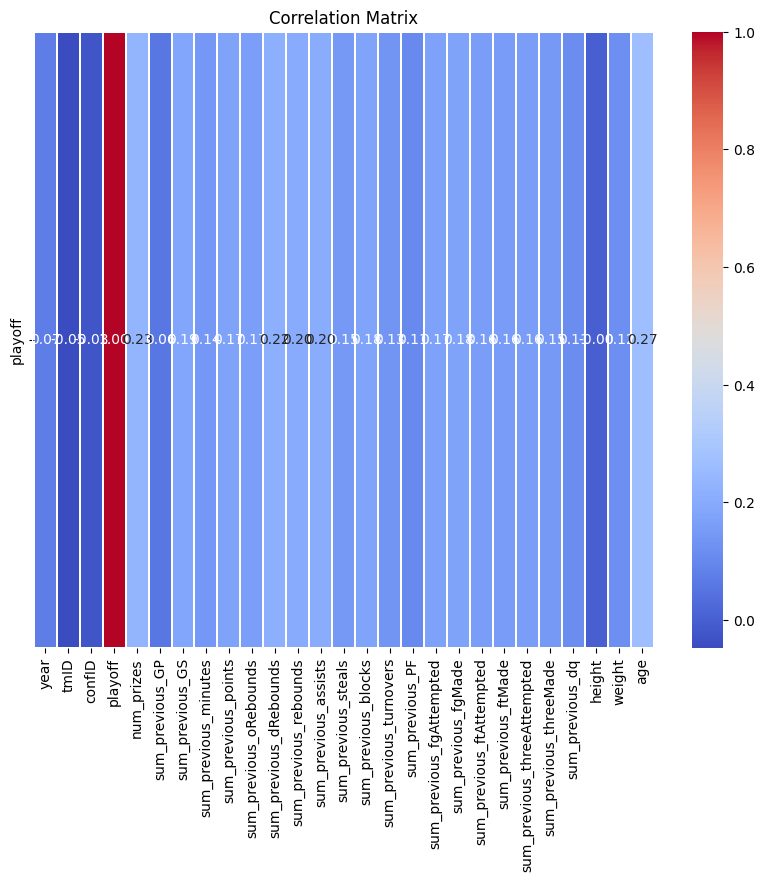

In [368]:
# Create a correlation matrix for all columns
correlation_matrix = train_data.corr()

# Set the size of the heatmap
plt.figure(figsize=(10, 8))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix[['playoff']].transpose(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.3)

# Set the title
plt.title("Correlation Matrix")

# Show the heatmap
plt.show()

In [369]:
""" teams_before = pd.read_csv('./Dataset/teams.csv')

print(teams_before.columns)
teams_before['playoff'] = label_encoder.fit_transform(teams_before['playoff'])
#teams['previous_playoff'] = label_encoder.fit_transform(teams['previous_playoff'])
teams_before['tmID'] = label_encoder.fit_transform(teams_before['tmID'])
teams_before['confID'] = label_encoder.fit_transform(teams_before['confID'])
teams_before['lgID'] = label_encoder.fit_transform(teams_before['lgID'])
teams_before['franchID'] = label_encoder.fit_transform(teams_before['franchID'])
teams_before['firstRound'] = label_encoder.fit_transform(teams_before['firstRound'])
teams_before['semis'] = label_encoder.fit_transform(teams_before['semis'])
teams_before['finals'] = label_encoder.fit_transform(teams_before['finals'])
teams_before['name'] = label_encoder.fit_transform(teams_before['name'])
teams_before['arena'] = label_encoder.fit_transform(teams_before['arena'])




train_data = teams_before[teams_before['year'] <= 9]
test_data = teams_before[teams_before['year'] == 10]

# Use the same train_data and test_data from your code
X_train = train_data.drop(['playoff'], axis=1)
y_train = train_data['playoff']
X_test = test_data.drop(['playoff'], axis=1)
y_test = test_data['playoff']

from sklearn.impute import SimpleImputer

# Initialize the imputer with a strategy (e.g., mean, median, most_frequent, constant)
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on your training data
X_train_imputed = imputer.fit_transform(X_train)

# Transform the imputer on your test data (using statistics learned from training data)
X_test_imputed = imputer.transform(X_test)

# Now, you can use X_train_imputed and X_test_imputed for training and testing your models

# Define a list of classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression(solver='liblinear', random_state=0)),
    ("Decision Tree", DecisionTreeClassifier(random_state=0)),
    ("Random Forest", RandomForestClassifier(random_state=0)),
    ("Support Vector Machine", SVC(kernel='linear', random_state=0)),
    ("K-Nearest Neighbors", KNeighborsClassifier())
]

# Create an empty dictionary to store accuracies
accuracies = {}

# Iterate through each classifier, train, predict, and store accuracy
for name, clf in classifiers:
    clf.fit(X_train_imputed, y_train)
    predictions = clf.predict(X_test_imputed)
    accuracy = accuracy_score(y_test, predictions)
    accuracies[name] = accuracy

# Print the accuracies for each model
for name, accuracy in accuracies.items():
    print(f"{name} Accuracy: {accuracy}")
 """

' teams_before = pd.read_csv(\'./Dataset/teams.csv\')\n\nprint(teams_before.columns)\nteams_before[\'playoff\'] = label_encoder.fit_transform(teams_before[\'playoff\'])\n#teams[\'previous_playoff\'] = label_encoder.fit_transform(teams[\'previous_playoff\'])\nteams_before[\'tmID\'] = label_encoder.fit_transform(teams_before[\'tmID\'])\nteams_before[\'confID\'] = label_encoder.fit_transform(teams_before[\'confID\'])\nteams_before[\'lgID\'] = label_encoder.fit_transform(teams_before[\'lgID\'])\nteams_before[\'franchID\'] = label_encoder.fit_transform(teams_before[\'franchID\'])\nteams_before[\'firstRound\'] = label_encoder.fit_transform(teams_before[\'firstRound\'])\nteams_before[\'semis\'] = label_encoder.fit_transform(teams_before[\'semis\'])\nteams_before[\'finals\'] = label_encoder.fit_transform(teams_before[\'finals\'])\nteams_before[\'name\'] = label_encoder.fit_transform(teams_before[\'name\'])\nteams_before[\'arena\'] = label_encoder.fit_transform(teams_before[\'arena\'])\n\n\n\n\